# Ejercicio

Para los siguientes puntos, utilizar la librería RAPIDS a la hora de implementar los algoritmos estudiados, en caso de estar disponibles.

* Realice una comparación de los métodos de clustering vistos, para generar una segmentación de imagen a color, incluyendo la información de ubicación de cada pixel (ver Cuaderno guía tanjiro). Varie la cantidad de grupos (niveles o clases de segmentación) y presente los scores de inercia y silueta conseguidos.

*  Repita el punto anterior realizando una proyección 2D de los datos con PCA y UMAP (ver guía reducción de dimensión) antes de generar las segmentaciones.

In [70]:
#https://drive.google.com/file/d/1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP/view?usp=sharing

FILEID = "1BAVqnQYCXrEPr5rHqgvWMkfZffBHHl_F"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O tanjiro.jpeg && rm -rf /tmp/cookies.txt
!pip install umap-learn

--2025-06-13 00:33:12--  https://docs.google.com/uc?export=download&confirm=&id=1BAVqnQYCXrEPr5rHqgvWMkfZffBHHl_F
Resolving docs.google.com (docs.google.com)... 74.125.24.113, 74.125.24.139, 74.125.24.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1BAVqnQYCXrEPr5rHqgvWMkfZffBHHl_F&export=download [following]
--2025-06-13 00:33:12--  https://drive.usercontent.google.com/download?id=1BAVqnQYCXrEPr5rHqgvWMkfZffBHHl_F&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4868 (4.8K) [image/jpeg]
Saving to: ‘tanjiro.jpeg’

tanjiro.jpeg        100%[===================>]   4.75K  --.-KB/s    in 0s      

20

(74, 105, 3)

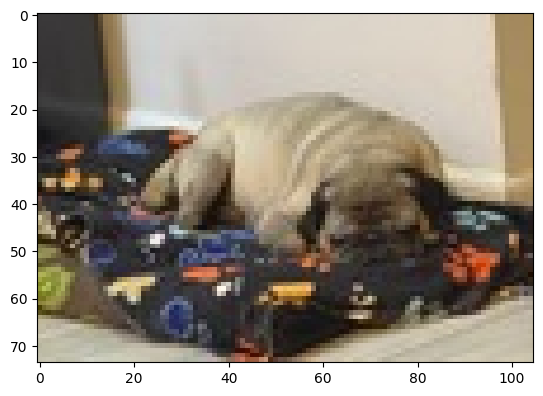

In [71]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
image = imread(os.path.join("tanjiro.jpeg"))
image = image[20:175,20:175,:]
plt.imshow(image)
image.shape

In [72]:
X = image.reshape(-1, 3)
r,c,ch = image.shape
print(r,c,ch)

74 105 3


In [73]:
vr = np.linspace(0,r,r,endpoint=False)
vc = np.linspace(0,c,c,endpoint=False)
Xc = np.kron(np.ones((r,1)),vc.reshape(-1,1))
Xr = np.kron(vr.reshape(-1,1),np.ones((1,c)))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)
X = np.c_[X,Xc,Xr]
X.shape

(7770, 5)

In [74]:
from cuml import UMAP, PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)
X_ = UMAP(n_components=2,n_neighbors = 30,#round(np.sqrt(X_.shape[0])),
          min_dist =0.9).fit_transform(X_)
X__ = PCA(n_components=2).fit_transform(X_)



[2025-06-13 00:33:18.958] [CUML] [info] Building knn graph using brute force


In [75]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4,n_init='auto').fit(X_)
kmeans.labels_

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

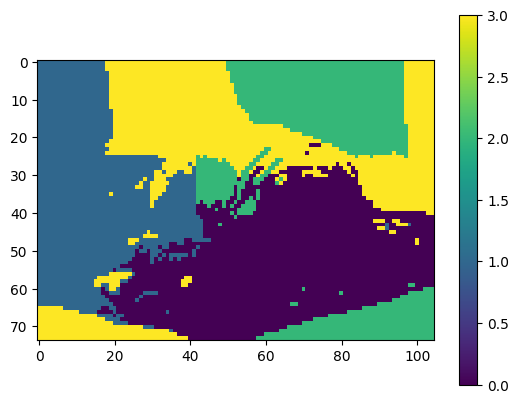

In [76]:
labels_ = kmeans.labels_
Ilabels = labels_.reshape(r,c)
plt.imshow(Ilabels)
plt.colorbar()
plt.show()

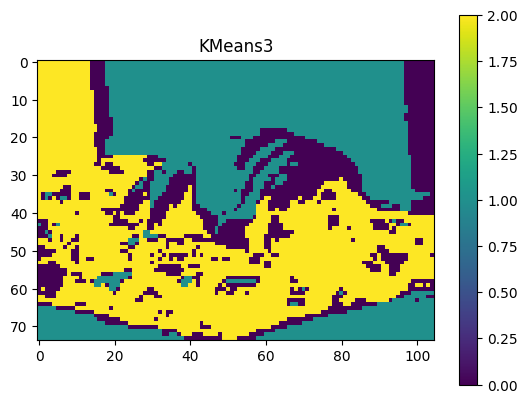

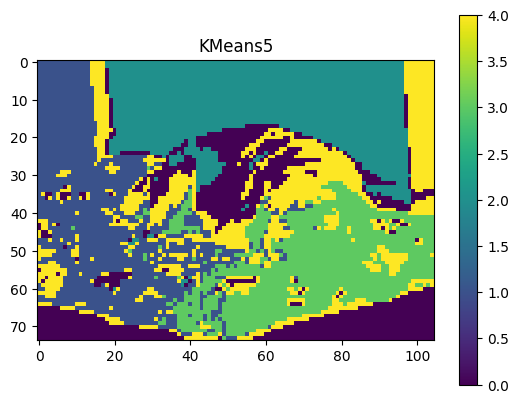

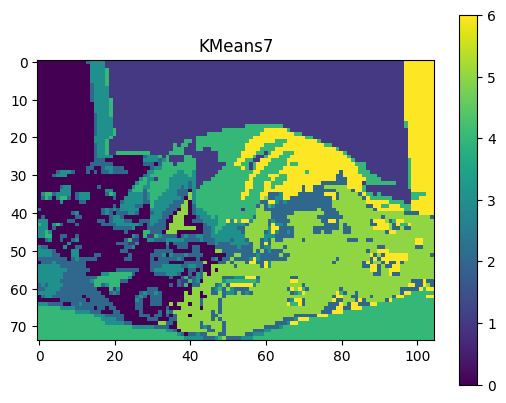

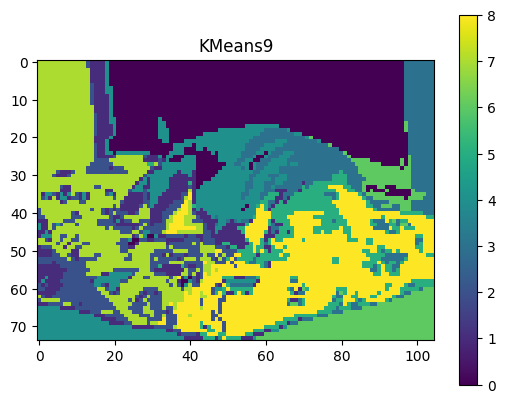

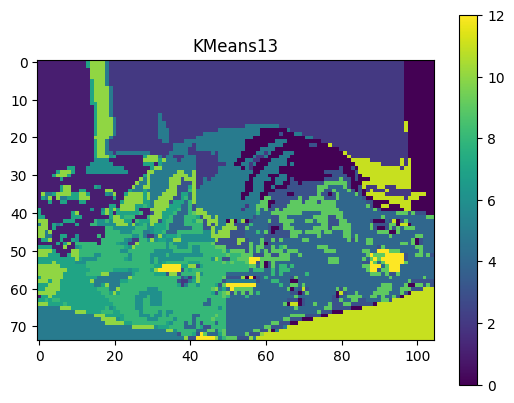

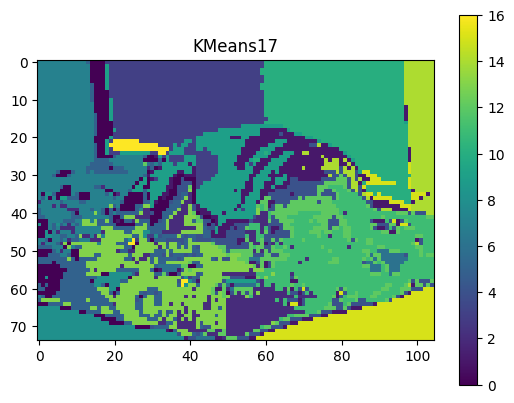

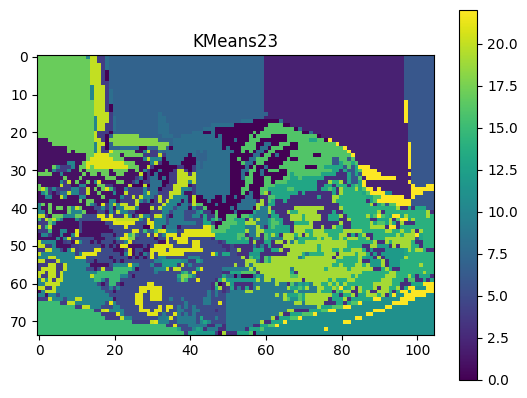

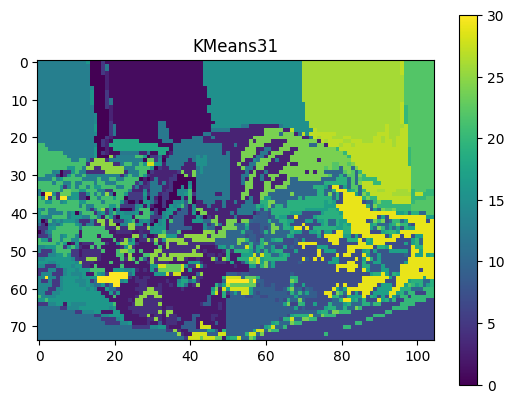

In [77]:
from cuml import KMeans, HDBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

def plot_labels(labels, model_name):
    Ilabels = labels_.reshape(r,c)
    plt.imshow(Ilabels)
    plt.colorbar()
    plt.title(model_name)
    plt.show()


clusters = [3, 5, 7, 9, 13, 17, 23, 31]

silhouettes = []
inertias = []

for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=1).fit(X)
    labels_ = kmeans.labels_
    plot_labels(labels_, f"KMeans{cluster}")
    silhouettes.append(silhouette_score(X, kmeans.labels_))
    inertias.append(kmeans.inertia_)


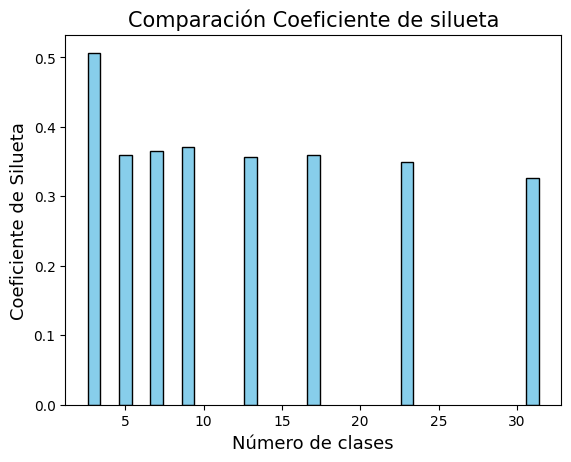

In [78]:
plt.bar(clusters, silhouettes, color='skyblue', edgecolor='black')
plt.ylabel('Coeficiente de Silueta', fontsize=13)
plt.title('Comparación Coeficiente de silueta', fontsize=15)
plt.xlabel('Número de clases', fontsize=13)
plt.show()

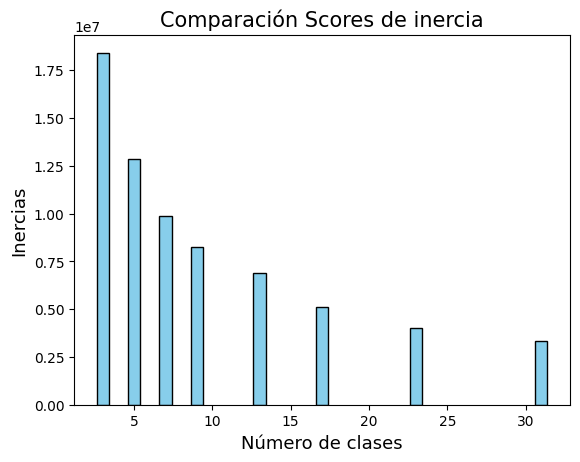

In [79]:
plt.bar(clusters, inertias, color='skyblue', edgecolor='black')
plt.ylabel('Inercias', fontsize=13)
plt.title('Comparación Scores de inercia', fontsize=15)
plt.xlabel('Número de clases', fontsize=13)
plt.show()

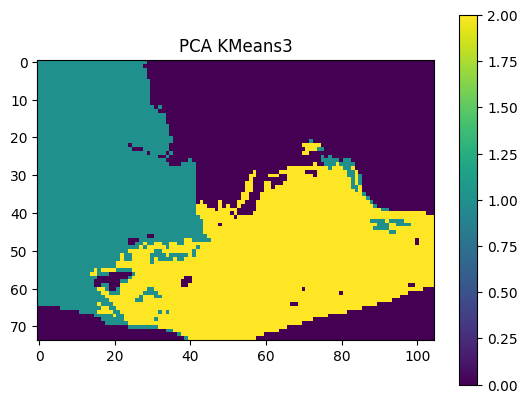

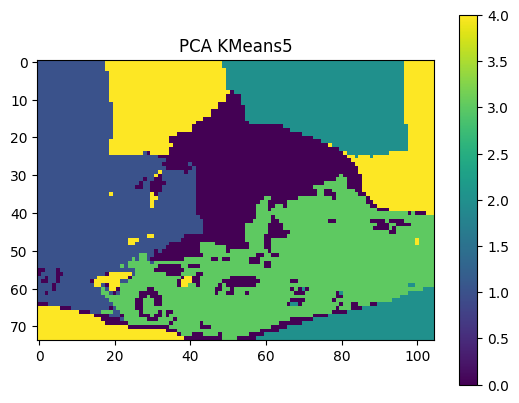

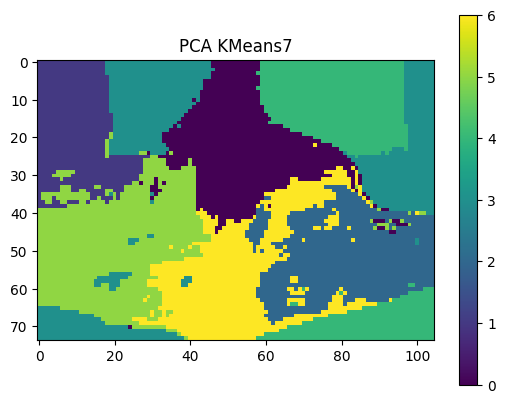

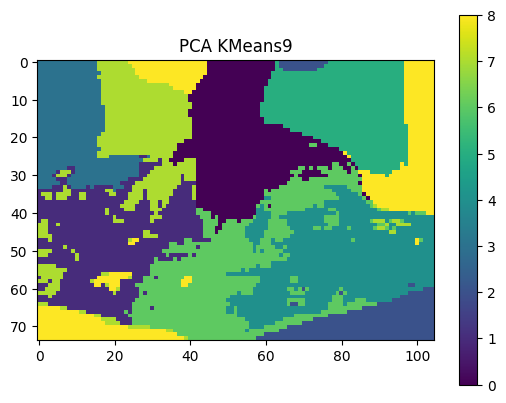

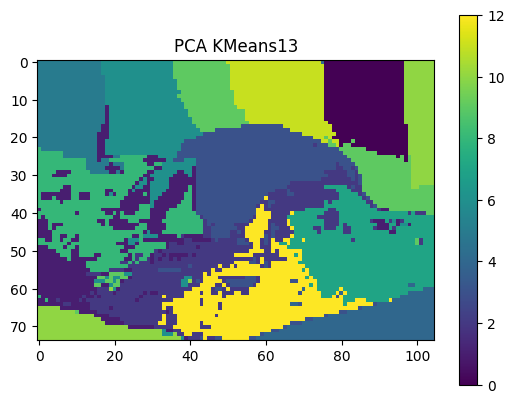

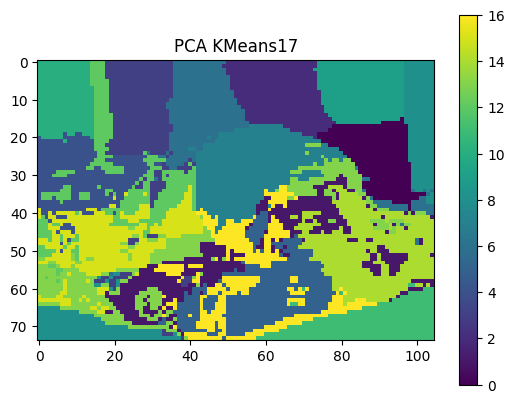

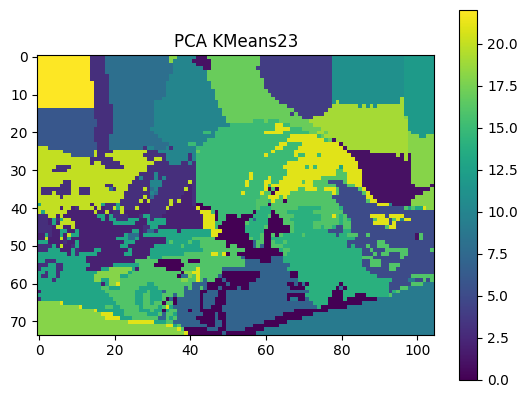

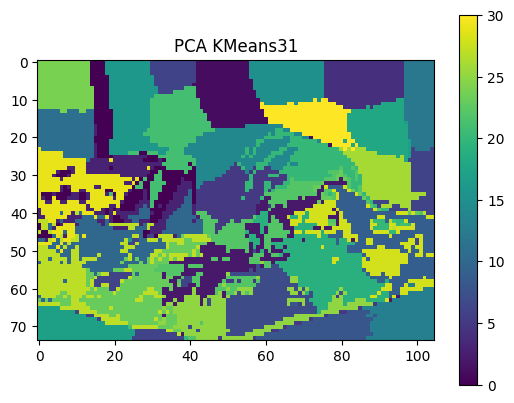

In [80]:
inertias = []
silhouettes = []

for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=1).fit(X__)
    labels_ = kmeans.labels_
    plot_labels(labels_, f"PCA KMeans{cluster}")
    silhouettes.append(silhouette_score(X__, kmeans.labels_))
    inertias.append(kmeans.inertia_)

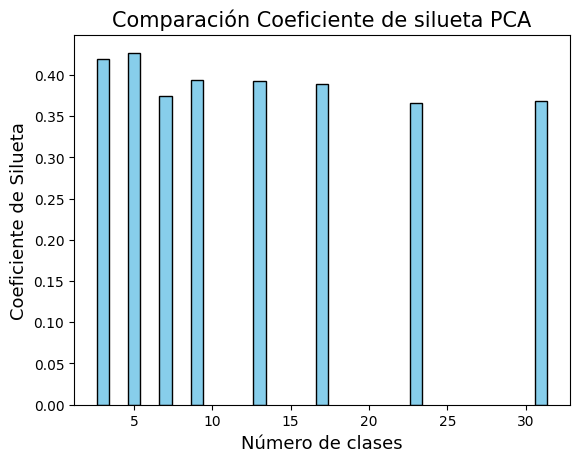

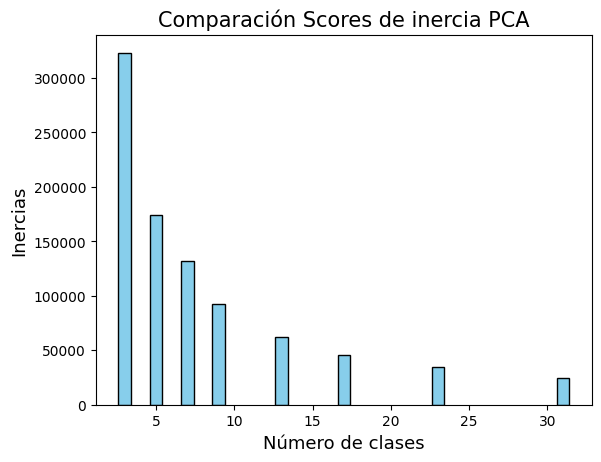

In [81]:
plt.bar(clusters, silhouettes, color='skyblue', edgecolor='black')
plt.ylabel('Coeficiente de Silueta', fontsize=13)
plt.title('Comparación Coeficiente de silueta PCA', fontsize=15)
plt.xlabel('Número de clases', fontsize=13)
plt.show()
plt.bar(clusters, inertias, color='skyblue', edgecolor='black')
plt.ylabel('Inercias', fontsize=13)
plt.title('Comparación Scores de inercia PCA', fontsize=15)
plt.xlabel('Número de clases', fontsize=13)
plt.show()

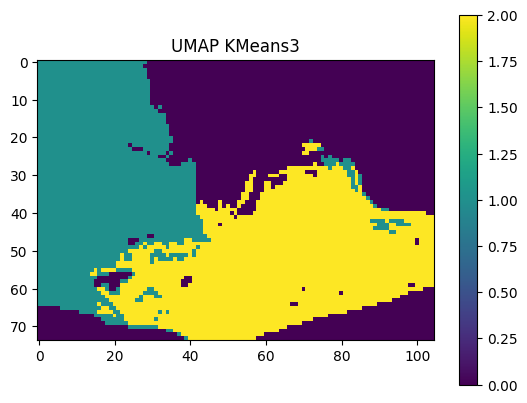

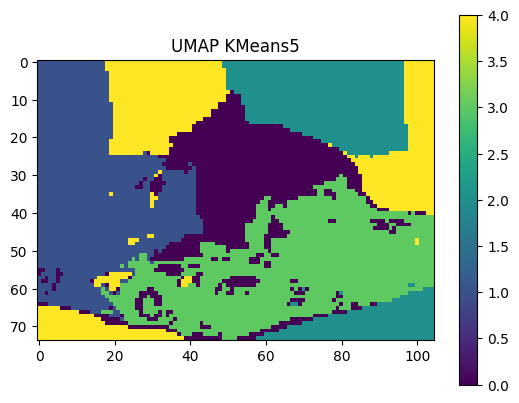

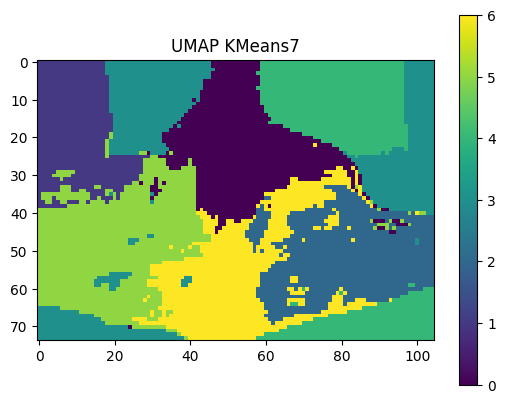

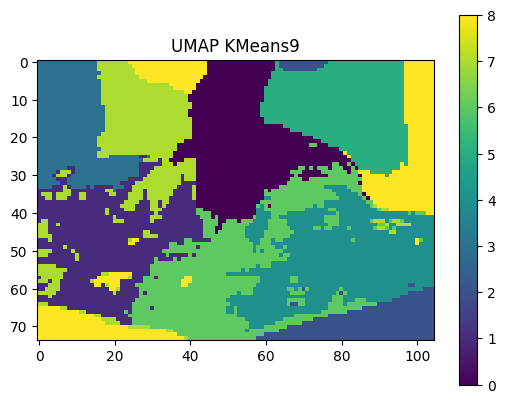

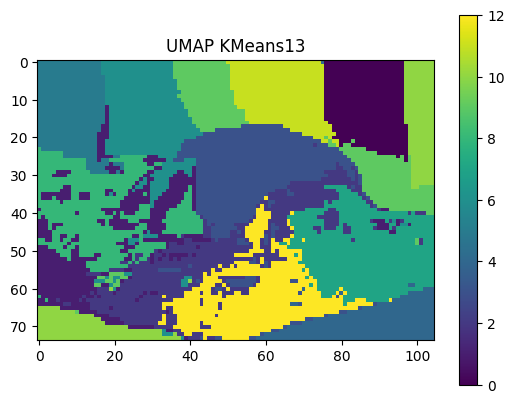

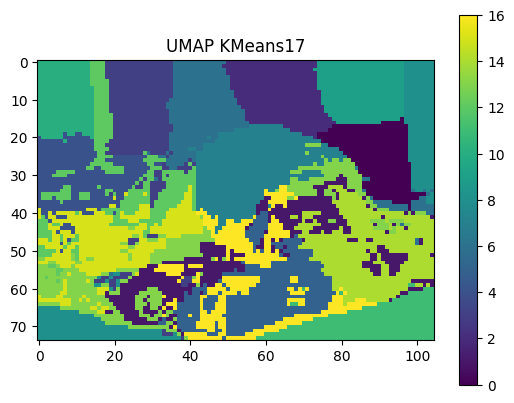

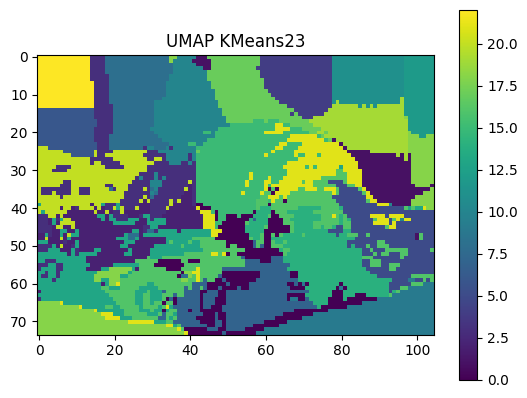

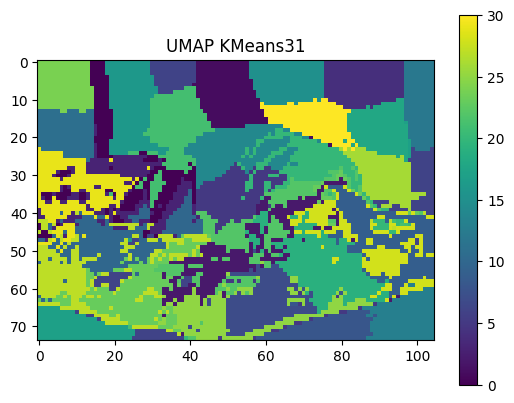

In [82]:
inertias = []
silhouettes = []

for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=1).fit(X_)
    labels_ = kmeans.labels_
    plot_labels(labels_, f"UMAP KMeans{cluster}")
    silhouettes.append(silhouette_score(X_, kmeans.labels_))
    inertias.append(kmeans.inertia_)

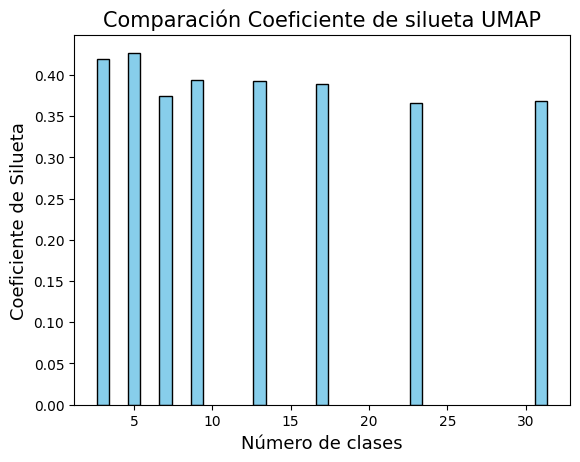

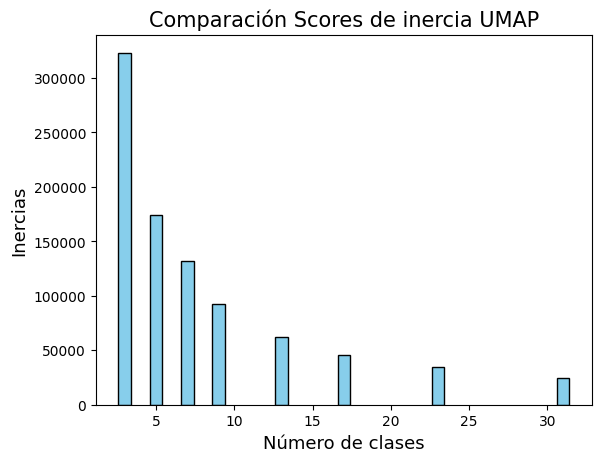

In [83]:
plt.bar(clusters, silhouettes, color='skyblue', edgecolor='black')
plt.ylabel('Coeficiente de Silueta', fontsize=13)
plt.title('Comparación Coeficiente de silueta UMAP', fontsize=15)
plt.xlabel('Número de clases', fontsize=13)
plt.show()
plt.bar(clusters, inertias, color='skyblue', edgecolor='black')
plt.ylabel('Inercias', fontsize=13)
plt.title('Comparación Scores de inercia UMAP', fontsize=15)
plt.xlabel('Número de clases', fontsize=13)
plt.show()